In [3]:
# encoding: utf-8
# import tensorflow as tf
import quandl
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.width', None)  # 设置字符显示宽度
pd.set_option('display.max_rows', None)  # 设置显示最大行
pd.set_option('display.max_columns', None)  # 设置显示最大列

quandl.ApiConfig.api_key = '-GGCYDJNb2cxMLTvqTho'
d = pd.read_excel(r'E:\code.xlsx', input_col=0,dtype={'code':str})
code = d[['品种简称', 'code']]
data2 = pd.DataFrame()
for temp in d['code']:
    try:
        data = quandl.get('CFTC/' + temp + '_F_L_ALL', paginate=True)
        data['code'] = temp
        # 净持仓
        data['大户净持仓'] = data.apply(lambda x: x['Noncommercial Long'] - x['Noncommercial Short'], axis=1)
        data['套保净持仓'] = data.apply(lambda x: x['Commercial Long'] - x['Commercial Short'], axis=1)
        data['散户净持仓'] = data.apply(lambda x: x['Nonreportable Positions Long'] - x['Nonreportable Positions Short'],axis=1)
        # 最大值最小值
        chg = data[['大户净持仓', '套保净持仓', '散户净持仓']]
        max = chg.rolling(window=156).max().dropna()
        min = chg.rolling(window=156).min().dropna()

        hb = pd.merge(max, min, on=['Date'], how='outer')
        hb1 = pd.merge(data, hb, on=['Date'], how='outer')
        # cot指标
        data['大户cot(%)'] = round(hb1.apply(lambda x: ((x['大户净持仓'] - x['大户净持仓_y']) / (x['大户净持仓_x'] - x['大户净持仓_y'])) * 100, axis=1), 2)
        data['套保cot(%)'] = round(hb1.apply(lambda x: ((x['套保净持仓'] - x['套保净持仓_y']) / (x['套保净持仓_x'] - x['套保净持仓_y'])) * 100, axis=1), 2)
        data['散户cot(%)'] = round(hb1.apply(lambda x: ((x['散户净持仓'] - x['散户净持仓_y']) / (x['散户净持仓_x'] - x['散户净持仓_y'])) * 100, axis=1), 2)

        data = data[['code', '大户净持仓', '套保净持仓', '散户净持仓', '大户cot(%)', '套保cot(%)', '散户cot(%)']]
        data = data.reset_index()
        data = pd.merge(data, code)
#         data = data[data['套保cot(%)']>=100 or data['套保cot(%)']<=0]
        data = data.tail(10)
        data2 = data2.append(data)
        
    except:
        print('? ?')
    continue

# data2=data2[data2['套保cot(%)']>=100 or data2['套保cot(%)']<=0]
data2



ModuleNotFoundError: No module named 'quandl'

# CFTC一览

<Figure size 432x288 with 0 Axes>

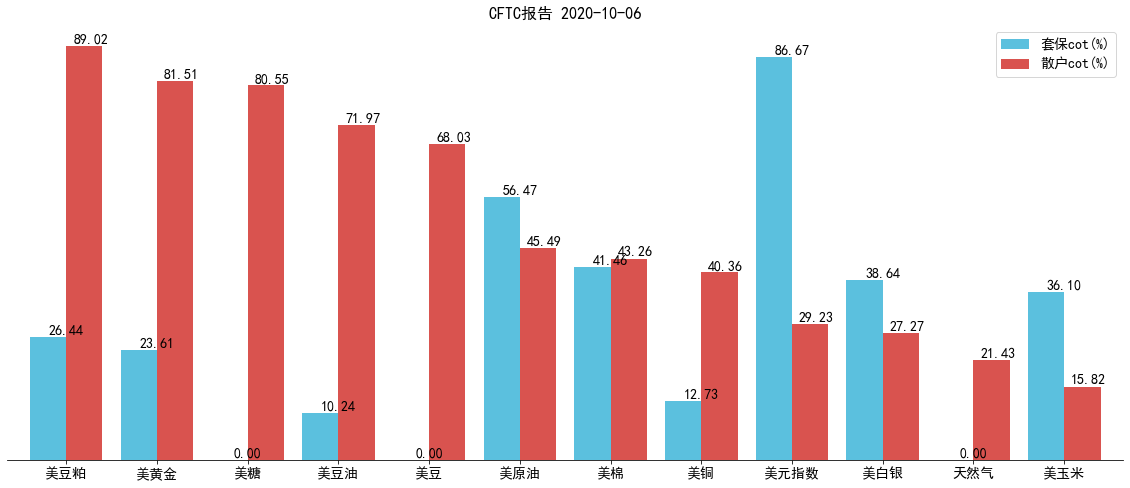

In [26]:
%matplotlib inline
#二行即可搞定画图中文乱码
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


dates=data2['Date'].dt.strftime("%Y-%m-%d")
dates=dates.drop_duplicates().reset_index(drop=True)
dates=dates.iloc[-1]

import matplotlib.pyplot as plt
import numpy as np
df=data2[data2['Date']>=dates]
# Sort the dataframe in descending order of Very interested. 降序排列
df=df.sort_values(by=['散户cot(%)'],ascending=False)

fig = plt.figure()
#use a figure size of (20, 8),bar width of 0.8, 设置图片大小，柱宽
#use color #5cb85c for the Very interested bars, 设置柱子颜色
#color #5bc0de for the Somewhat interested bars,
#color #d9534f for the Not interested bars,
c=df.plot(kind='bar', y=['套保cot(%)','散户cot(%)'],figsize=(20, 8),width=0.8,
           color=['#5bc0de','#d9534f'],fontsize=14)

codes=range(len(df.index))
#use font size 14 for the bar labels, percentages, and legend, 图例颜色
plt.xticks(codes,df['品种简称'])#x轴标更改
plt.legend(fontsize=14)
plt.xticks(rotation=360)#旋转角度

# plt.yticks([]) # y轴空轴
#use font size 16 for the title, and, 标题字号
plt.title("CFTC报告 "+dates,fontsize=16)

plt.yticks([]) # y轴空轴
#display the percentages above the bars as shown above 数据标签列表
x=np.arange(len(df.index))
# yv=np.array(list(df['大户cot(%)']))
ys=np.array(list(df['套保cot(%)']))
yn=np.array(list(df['散户cot(%)']))
# for a,b in zip(x,yv): ##控制标签位置
#     plt.text(a-0.27,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=14)
for a,b in zip(x,ys):
    plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=14)
for a,b in zip(x,yn):
    plt.text(a+0.27,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=14)
#remove the left, top, and right borders. 去掉图片边框
c.spines['top'].set_visible(False)
c.spines['right'].set_visible(False)
#c.spines['bottom'].set_visible(False) 保留横坐标边框
c.spines['left'].set_visible(False)
plt.show()

# 高质量见顶信号

In [24]:
%matplotlib inline
#二行即可搞定画图中文乱码
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


dates=data2['Date'].dt.strftime("%Y-%m-%d")
dates=dates.drop_duplicates().reset_index(drop=True)
dates=dates.iloc[-1]

import matplotlib.pyplot as plt
import numpy as np
df=data2[data2['Date']>=dates]
df=df[df['散户cot(%)']>=100]
df=df[df['套保cot(%)']<=5]
if df.shape[0]==0 :
    print(' ')
if df.shape[0]>0 :
    # Sort the dataframe in descending order of Very interested. 降序排列
    df=df.sort_values(by=['散户cot(%)'],ascending=False)

    fig = plt.figure()
    #use a figure size of (20, 8),bar width of 0.8, 设置图片大小，柱宽
    #use color #5cb85c for the Very interested bars, 设置柱子颜色
    #color #5bc0de for the Somewhat interested bars,
    #color #d9534f for the Not interested bars,
    c=df.plot(kind='bar', y=['套保cot(%)','散户cot(%)'],figsize=(20, 8),width=0.8,
               color=['#5bc0de','#d9534f'],fontsize=14)

    codes=range(len(df.index))
    #use font size 14 for the bar labels, percentages, and legend, 图例颜色
    plt.xticks(codes,df['品种简称'])#x轴标更改
    plt.legend(fontsize=14)
    plt.xticks(rotation=360)#旋转角度

    # plt.yticks([]) # y轴空轴
    #use font size 16 for the title, and, 标题字号
    plt.title("CFTC报告 见顶信号 "+dates,fontsize=16)

    plt.yticks([]) # y轴空轴
    #display the percentages above the bars as shown above 数据标签列表
    x=np.arange(len(df.index))
    # yv=np.array(list(df['大户cot(%)']))
    ys=np.array(list(df['套保cot(%)']))
    yn=np.array(list(df['散户cot(%)']))
    # for a,b in zip(x,yv): ##控制标签位置
    #     plt.text(a-0.27,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=14)
    for a,b in zip(x,ys):
        plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=14)
    for a,b in zip(x,yn):
        plt.text(a+0.27,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=14)
    #remove the left, top, and right borders. 去掉图片边框
    c.spines['top'].set_visible(False)
    c.spines['right'].set_visible(False)
    #c.spines['bottom'].set_visible(False) 保留横坐标边框
    c.spines['left'].set_visible(False)
    plt.show()
    


CFTC没有出现见顶信号


# 高质量见底信号

In [25]:
%matplotlib inline
#二行即可搞定画图中文乱码
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


dates=data2['Date'].dt.strftime("%Y-%m-%d")
dates=dates.drop_duplicates().reset_index(drop=True)
dates=dates.iloc[-1]

import matplotlib.pyplot as plt
import numpy as np
df=data2[data2['Date']>=dates]
df=df[df['散户cot(%)']<=0]
df=df[df['套保cot(%)']>=95]
if df.shape[0]==0 :
    print(' ')
if df.shape[0]>0 :
    # Sort the dataframe in descending order of Very interested. 降序排列
    df=df.sort_values(by=['散户cot(%)'],ascending=False)

    fig = plt.figure()
    #use a figure size of (20, 8),bar width of 0.8, 设置图片大小，柱宽
    #use color #5cb85c for the Very interested bars, 设置柱子颜色
    #color #5bc0de for the Somewhat interested bars,
    #color #d9534f for the Not interested bars,
    c=df.plot(kind='bar', y=['套保cot(%)','散户cot(%)'],figsize=(20, 8),width=0.8,
               color=['#5bc0de','#d9534f'],fontsize=14)

    codes=range(len(df.index))
    #use font size 14 for the bar labels, percentages, and legend, 图例颜色
    plt.xticks(codes,df['品种简称'])#x轴标更改
    plt.legend(fontsize=14)
    plt.xticks(rotation=360)#旋转角度

    # plt.yticks([]) # y轴空轴
    #use font size 16 for the title, and, 标题字号
    plt.title("CFTC报告 见底信号 "+dates,fontsize=16)

    plt.yticks([]) # y轴空轴
    #display the percentages above the bars as shown above 数据标签列表
    x=np.arange(len(df.index))
    # yv=np.array(list(df['大户cot(%)']))
    ys=np.array(list(df['套保cot(%)']))
    yn=np.array(list(df['散户cot(%)']))
    # for a,b in zip(x,yv): ##控制标签位置
    #     plt.text(a-0.27,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=14)
    for a,b in zip(x,ys):
        plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=14)
    for a,b in zip(x,yn):
        plt.text(a+0.27,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=14)
    #remove the left, top, and right borders. 去掉图片边框
    c.spines['top'].set_visible(False)
    c.spines['right'].set_visible(False)
    #c.spines['bottom'].set_visible(False) 保留横坐标边框
    c.spines['left'].set_visible(False)
    plt.show()

CFTC报告没有出现见底信号


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美原油'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    

    
plt.xlabel('日期')
plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=15)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美豆'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    

    

plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=45)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美豆油'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    


plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=45)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美豆粕'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    

    
plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=45)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美铜'
fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    

    
plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=45)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美黄金'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    

    
plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=45)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美白银'
fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    

    
plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=45)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美棉'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    


plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=45)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美糖'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    

    

plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=45)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美元指数'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    


plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=45)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='美玉米'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    

plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=15)

plt.show()

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

symbol='天然气'

fig = plt.figure(figsize=(16,8))#
df=data2[data2['品种简称']==symbol]
df=df[['Date','大户cot(%)','套保cot(%)','散户cot(%)','品种简称']]

x=df['Date']
y1=df['大户cot(%)']
y2=df['套保cot(%)']
y3=df['散户cot(%)']


# w=41,k=2的平滑效果最明显。即window_length越大，polyorder越小，则平滑效果越强
# w=21,k=4最接近原曲线。即window_length越小，polyorder越大，则结果越接近原始曲线。
# y11=scipy.signal.savgol_filter(x,53,3)
# y22=scipy.signal.savgol_filter(x,53,3)

# plt.semilogx(f,tmp*0.5,label = 'mic'+str(num+1))
# plt.semilogx(f,y11*0.5,label = 'mic'+str(num+1)+'拟合曲线-21',color = 'red')
# plt.semilogx(f,tmp_smooth2*0.5,label = 'mic'+str(num+1)+'拟合曲线-53',color = 'green')

# plt.plot(x,y11)

plt.plot(x,y2,color='#5bc0de',label='套保')
plt.plot(x,y3,color='red',label='散户')

for a,b in zip(x, y2):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)   
for a,b in zip(x, y3):
    plt.text(a, b+0.3, str(b), ha='center', va='bottom', fontsize=10.5)
    

    
plt.ylabel('cot(%)')
plt.title(symbol+' '+dates,fontsize=16)

plt.legend(fontsize=12)

plt.xticks(rotation=15)

plt.show()

NameError: name 'data2' is not defined

<Figure size 1152x576 with 0 Axes>